In [2]:
import json
import os
from pathlib import Path

import arviz as az
import numpy as np
import pandas as pd
import scipy
import xarray

from matplotlib import pyplot as plt
from pprint import pprint

from equilibrator_api import ComponentContribution
from dgfreg.data_preparation import load_prepared_data

INFERENCES_DIR = os.path.join("..", "inferences")
PLOTS_DIR = os.path.join("..", "docs", "plots")
ARVIZ_STYLE = "arviz-redish"

plt.style.use(ARVIZ_STYLE)

In [3]:
idata_c = az.from_json(os.path.join(INFERENCES_DIR, "equilibrator_component", "idata.json"))
idata_c

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data

(array([1.100000e+01, 3.370000e+02, 1.247000e+04, 2.035720e+05,
        1.059924e+06, 1.033608e+06, 2.005720e+05, 1.314400e+04,
        3.560000e+02, 6.000000e+00]),
 array([-43.7453 , -34.98331, -26.22132, -17.45933,  -8.69734,   0.06465,
          8.82664,  17.58863,  26.35062,  35.11261,  43.8746 ]),
 <BarContainer object of 10 artists>)

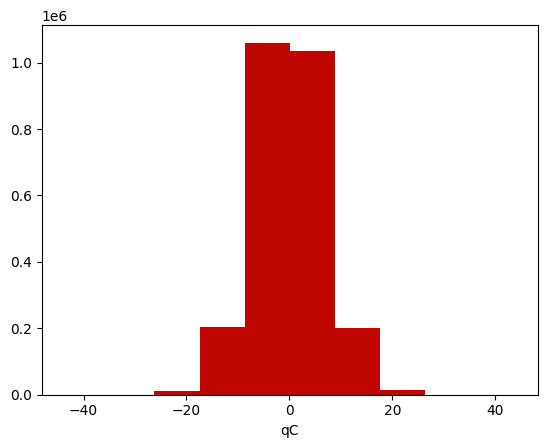

In [4]:
idata_c.posterior.qC.plot.hist()

We have quite a bit of variance in our eta values. That's interesting. Let's get the mean per compound.

In [23]:
compound_means = idata_c.posterior.qC.mean(dim=["chain", "draw"])
compound_means.to_series()["11"]

1.502551305419746

<Axes: xlabel='compound_id'>

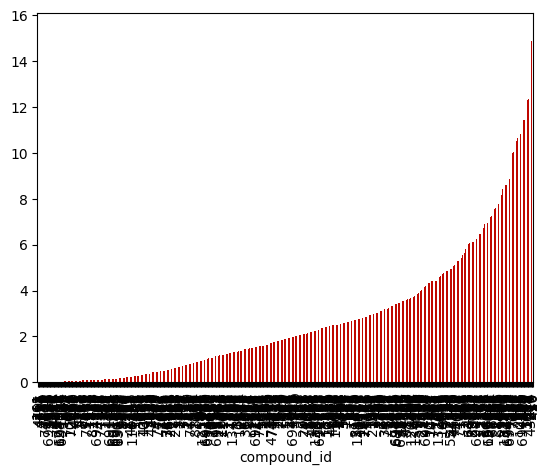

In [5]:
sorted_means = compound_means.to_series().abs().sort_values()
sorted_means.plot.bar()

In [6]:
sorted_means[-10:]

compound_id
1023     12.111644
3789     12.232892
1058     12.326167
73       12.326235
514      13.352824
248      14.077932
417      14.693819
43314    14.884073
210      15.002435
420      15.340689
Name: qC, dtype: float64

# Gathering the data from our model

In [7]:
idata_c.observed_data.coords["observation"] = idata_c.posterior_predictive.coords["observation"]
idata_c.observed_data["y"] = idata_c.observed_data["y"].rename({"y_dim_0": "observation"})

dgfC_draws = idata_c.posterior["dgfC"]
dgfG_draws = idata_c.posterior["dgfG"]
dgr_draws = idata_c.posterior["dgr"]

dgfC_qs = dgfC_draws.quantile([0.01, 0.5, 0.99], dim=["chain", "draw"]).to_series().unstack("quantile").add_prefix("q")
dgfC_qs.index = dgfC_qs.index.astype(int)

dgr_qs = dgr_draws.quantile([0.01, 0.5, 0.99], dim=["chain", "draw"]).to_series().unstack("quantile").add_prefix("q")
dgr_qs.index = dgr_qs.index.astype(int)

yrep_qs = idata_c.posterior_predictive["yrep"].quantile([0.01, 0.5, 0.99], dim=["chain", "draw"]).to_series().unstack("quantile").add_prefix("yrepq")
yrep_qs.index = dgr_qs.index.astype(int)

resids = idata_c.posterior_predictive["yrep"] - idata_c.observed_data["y"]
resid_qs = resids.quantile([0.01, 0.5, 0.99], dim=["chain", "draw"]).to_series().unstack("quantile").add_prefix("resid_q")
resid_qs.index = resid_qs.index.astype(int)
resid_qs = resid_qs.rename_axis("reaction_id")
resid_mean = idata_c.posterior_predictive["yrep"].mean(dim=["chain", "draw"]) - idata_c.observed_data["y"]

az.summary(idata_c, var_names=["tauC", "sigma", "mae"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
tauC,6.492,0.498,5.614,7.440,0.023,0.016,459.0,1299.0,1.0
sigma,7.571,0.476,6.671,8.477,0.020,0.014,575.0,1475.0,1.0
mae,4.776,0.264,4.265,5.253,0.012,0.008,510.0,1348.0,1.0


# Gathering the CC estimates

In [43]:
#TODO: Narrow this down to what we need
cc = ComponentContribution()
cc_cov = pd.read_csv(Path.cwd().parent / "data" / "raw" / "dgf_cov.csv").rename(columns={"Unnamed: 0": "compound_id"}).set_index("compound_id")
cc_cov.columns = map(int, cc_cov.columns)
sd_cc = pd.Series(np.sqrt(np.diag(cc_cov)), index=cc_cov.index).rename("sd_cc")

dgr_gc = (cc.predictor.params.train_G.T @ cc.predictor.params.train_S).T @ cc.predictor.params.dG0_gc
dgr_cc = cc.predictor.params.train_S.T @ cc.predictor.params.dG0_cc
dgf_gc = cc.predictor.params.train_G @ cc.predictor.params.dG0_gc
dgf_rc = cc.predictor.params.train_S.T @ cc.predictor.params.dG0_rc

prepped = load_prepared_data(Path.cwd().parent / "data" / "prepared" / "equilibrator")

measurements = prepped.measurements.set_index("measurement_id")
measurements["dgr_gc"] = dgr_gc
measurements["dgr_cc"] = dgr_cc
measurements["resid_cc"] = dgr_cc - measurements["y"]
measurements["resid_gc"] = dgr_gc - measurements["y"]

G = prepped.G.set_index(["compound_id", "group_id"])["stoichiometric_coefficient"].unstack().fillna(0.0)
S = prepped.S.set_index(["compound_id", "reaction_id"])["stoichiometric_coefficient"].unstack().fillna(0.0)

reactions = prepped.reactions.set_index("reaction_id")
reactions["conserves_groups"] = (G.T @ S).abs().sum() == 0
if "q0.5" not in reactions.columns:
    reactions = reactions.join(dgr_qs)
if "resid_q0.5" not in reactions.columns:
    reactions = reactions.join(resid_qs)
reactions["resid_mean"] = resid_mean
reactions["dgr_cc"] = measurements.groupby("reaction_id")["dgr_cc"].first()
reactions["dgr_gc"] = measurements.groupby("reaction_id")["dgr_gc"].first()
reactions = reactions.join(measurements.groupby("reaction_id").agg({"y": ["mean", "count"]})["y"].add_prefix("y_"))

if "q0.5" not in measurements.columns:
    measurements = measurements.join(resid_qs, on="reaction_id")

compounds = prepped.compounds.set_index("compound_id")
compounds["dgf_gc"] = dgf_gc
compounds["dgf_rc"] = dgf_rc
compounds["sd_cc"] = sd_cc
compounds["q0.01_cc"], compounds["q0.99_cc"] = compounds["dgf_cc"] - 2.33 * sd_cc, compounds["dgf_cc"] + 2.33 * sd_cc
if "q0.5" not in compounds.columns:
    compounds = compounds.join(dgfC_qs)
compounds["eta_mean"] = idata_c.posterior.qC.mean(dim=["chain", "draw"])
compounds["abs_eta_mean"] = compounds["eta_mean"].abs()
compounds.head()

,inchi_key,smiles,common_name,dgf_cc,mass,is_e_coli_ccm,dgf_gc,dgf_rc,sd_cc,q0.01_cc,q0.99_cc,q0.01,q0.5,q0.99,eta_mean,abs_eta_mean
compound_id,,,,,,,,,,,,,,,,
5,XLYOFNOQVPJJNP-UHFFFAOYSA-N,O,H2O,-238.136712,18.015,True,-236.528456,-5.136125,0.759034,-239.905262,-236.368163,-243.281390,-239.51800,-235.655930,0.140338,0.140338
6,ZKHQWZAMYRWXGA-KQYNXXCUSA-J,NC1=C2N=CN([C@@H]3O[C@H](COP([O-])(=O)OP([O-])...,ATP,-2811.578332,503.151,True,-2811.626734,-5.136125,1.489986,-2815.049998,-2808.106666,-2821.550400,-2812.60000,-2804.129400,4.027932,4.027932
7,MYMOFIZGZYHOMD-UHFFFAOYSA-N,O=O,O2,16.400000,31.998,True,16.400000,-5.136125,2.931871,9.568741,23.231259,-1.170201,16.56795,34.083957,0.042753,0.042753
8,XJLXINKUBYWONI-NNYOXOHSSA-K,NC(=O)C1=C[N+](=CC=C1)[C@@H]1O[C@H](COP([O-])(...,Nicotinamide adenine dinucleotide phosphate,-3098.931269,740.386,True,-3099.154329,-5.136125,6.831885,-3114.849562,-3083.012977,-3116.660300,-3087.84000,-3058.879100,-1.772476,1.772476
9,ACFIXJIJDZMPPO-NNYOXOHSSA-J,NC(=O)C1=CN(C=CC1)[C@@H]1O[C@H](COP([O-])(=O)O...,Nicotinamide adenine dinucleotide phosphate - ...,-3070.526029,741.394,True,-3070.422023,-5.136125,6.829013,-3086.437630,-3054.614428,-3087.774600,-3058.85000,-3030.948700,2.029323,2.029323


We need to see how many unique reactions each met is involved in as well. We'll need a few to find a correlation.

In [13]:
n_met_mes = pd.Series(index=compounds.index, dtype=float)
for met in n_met_mes.index:
    met_rxns = S.columns[S.loc[met] != 0]
    met_measurements = measurements[measurements["reaction_id"].isin(met_rxns)]
    n_met_mes[met] = met_measurements["reaction_id"].nunique()

In [86]:
compounds["n_unique_rxns"] = n_met_mes

In [15]:
compounds.sort_values(["n_unique_rxns", "abs_eta_mean"], ascending=False)[["common_name", "abs_eta_mean", "eta_mean", "n_unique_rxns"]].head(20)

,common_name,abs_eta_mean,eta_mean,n_unique_rxns
compound_id,,,,
5,H2O,0.140338,0.140338,102.0
11,Nicotinamide adenine dinucleotide,1.502551,1.502551,77.0
13,Nicotinamide adenine dinucleotide - reduced,2.103446,2.103446,75.0
12,Phosphate,0.028341,0.028341,55.0
6,ATP,4.027932,4.027932,47.0
8,Nicotinamide adenine dinucleotide phosphate,1.772476,-1.772476,40.0
9,Nicotinamide adenine dinucleotide phosphate - ...,2.029323,2.029323,39.0
10,ADP,0.785493,-0.785493,39.0
25,Pyruvate,5.935244,5.935244,36.0


In [16]:
candidates = compounds.loc[(compounds["n_unique_rxns"] > 10) & (compounds["abs_eta_mean"] > 5)]

/tmp/ipykernel_8962/233913851.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  can_measurements["coeff"] = S.loc[candidate, can_measurements["reaction_id"]].to_numpy()
/tmp/ipykernel_8962/233913851.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  can_measurements["coeff"] = S.loc[candidate, can_measurements["reaction_id"]].to_numpy()
/tmp/ipykernel_8962/233913851.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = 

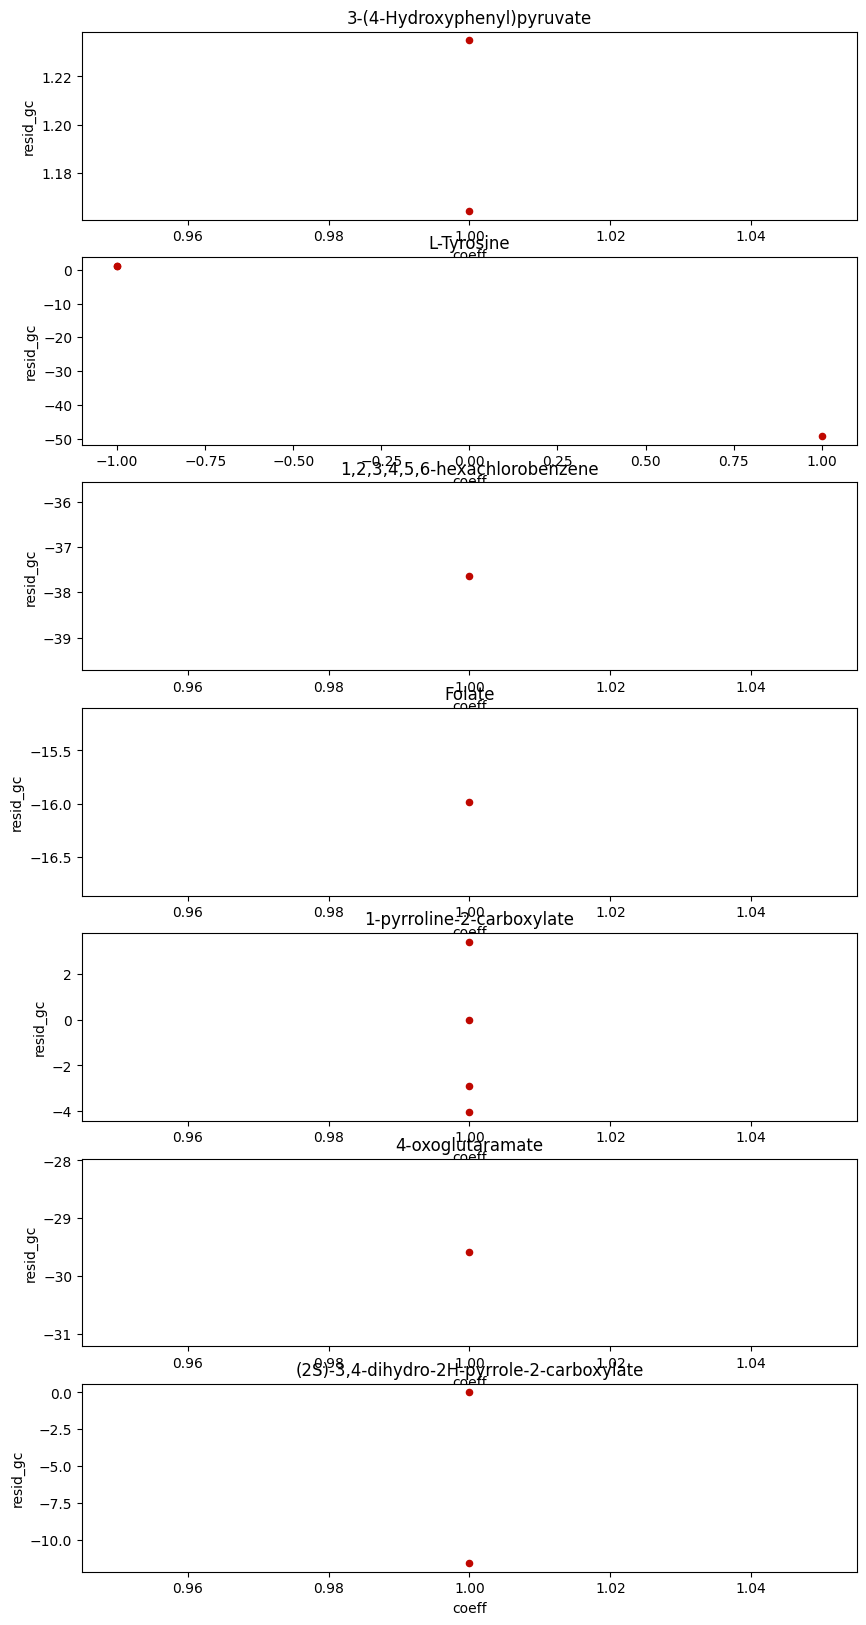

In [80]:
fig, axs = plt.subplots(len(candidates), figsize=(10, 20))
for i, candidate in enumerate(candidates.index):
    name = compounds.loc[candidate, "common_name"]
    rxns = S.loc[candidate]
    rxn_ids = S.columns[rxns != 0]
    can_measurements = measurements[measurements["reaction_id"].isin(rxn_ids)]
    can_measurements["coeff"] = S.loc[candidate, can_measurements["reaction_id"]].to_numpy()
    can_measurements.plot.scatter("coeff", "resid_gc", ax=axs[i])
    axs[i].set_title(name)

#TODO: Do the same, but with dgf residuals for the model

# RC/GC investigation
Something that we definitely expect to correlate with residuals is the difference between very accurate reactant contribution estimates, and the GC dgf estimates. Basically, if the dgf of a compound is underestimated, then we expect the dgr all reactions that consume that compound to be overestimated, and those that produce it to be underestimated. 

In [87]:
compounds["rc_cc_diff"] = compounds["dgf_gc"] - compounds["dgf_cc"]

In [111]:
compounds.loc[compounds["n_unique_rxns"] > 5, ["common_name", "rc_cc_diff", "n_unique_rxns"]].sort_values("rc_cc_diff", ascending=False).head(20)

,common_name,rc_cc_diff,n_unique_rxns
compound_id,,,
28,Acetate,11.405156,9.0
14,Diphosphate,11.275297,31.0
74381,D-Glucose 1-phosphate,9.324496,18.0
152,D-Glucose 6-phosphate,7.441060,11.0
74378,L-Glutamate,6.853130,26.0
12,Phosphate,6.675458,55.0
23,Acetyl-CoA,5.798060,14.0
51,GTP,5.700838,7.0
117,IMP,5.482011,6.0


In [104]:
candidates = compounds.loc[(compounds["n_unique_rxns"] > 5) & (compounds["rc_cc_diff"] > 5)]

In [107]:
candidates[["common_name", "rc_cc_diff", "n_unique_rxns"]]

,common_name,rc_cc_diff,n_unique_rxns
compound_id,,,
12,Phosphate,6.675458,55.0
14,Diphosphate,11.275297,31.0
23,Acetyl-CoA,5.798060,14.0
28,Acetate,11.405156,9.0
44,1-deoxy-1-(N6-lysino)-D-fructose,5.163222,9.0
51,GTP,5.700838,7.0
117,IMP,5.482011,6.0
152,D-Glucose 6-phosphate,7.441060,11.0
74378,L-Glutamate,6.853130,26.0


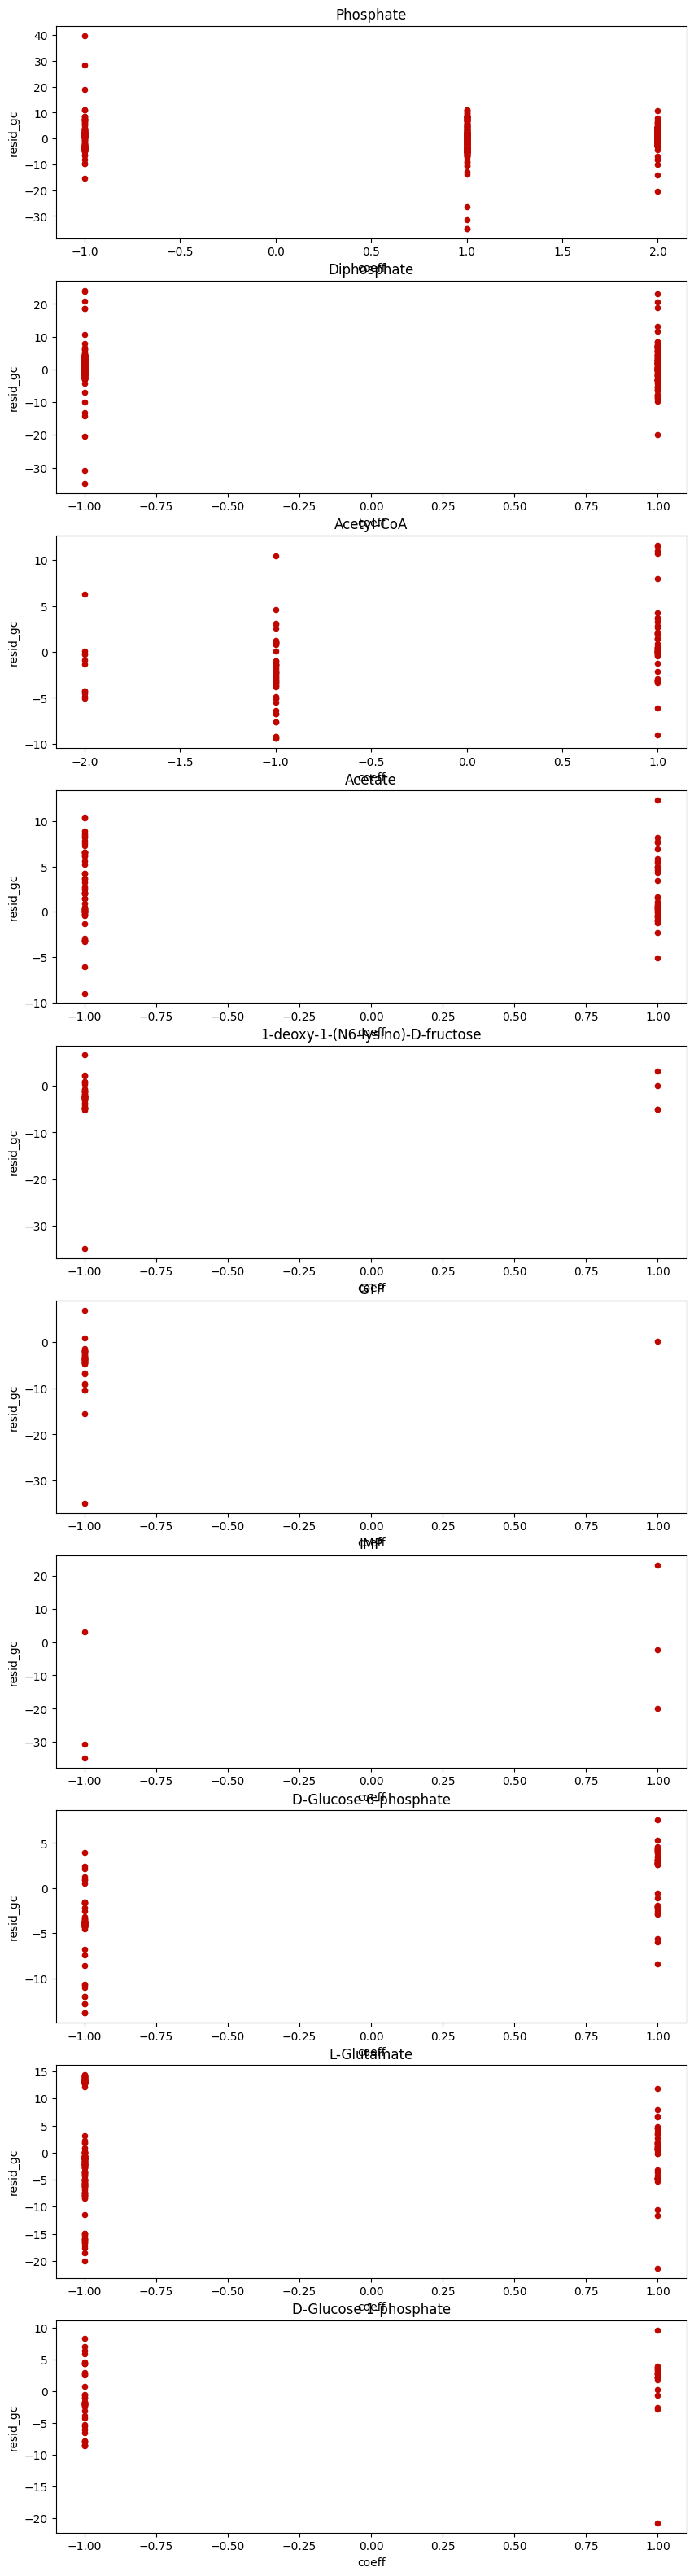

In [105]:
fig, axs = plt.subplots(len(candidates), figsize=(10, 40))
for i, candidate in enumerate(candidates.index):
    name = compounds.loc[candidate, "common_name"]
    rxns = S.loc[candidate]
    rxn_ids = S.columns[rxns != 0]
    can_measurements = measurements[measurements["reaction_id"].isin(rxn_ids)].copy()
    can_measurements["coeff"] = S.loc[candidate, can_measurements["reaction_id"]].to_numpy()
    can_measurements.plot.scatter("coeff", "resid_gc", ax=axs[i])
    axs[i].set_title(name)

# Systematic comparison
Here I tried to project all differences with S into the space of reactions. Basically, a reaction that consumes a compound with a large positive deviation and produces a compound with a large negative deviation, should have an even larger residual. 

In [121]:
compounds.columns

Index(['inchi_key', 'smiles', 'common_name', 'dgf_cc', 'mass', 'is_e_coli_ccm',
       'dgf_gc', 'dgf_rc', 'sd_cc', 'q0.01_cc', 'q0.99_cc', 'q0.01', 'q0.5',
       'q0.99', 'eta_mean', 'abs_eta_mean', 'rc_cc_diff', 'n_unique_rxns'],
      dtype='object')

In [123]:
rxn_diff = S.T @ compounds["rc_cc_diff"]

In [124]:
reactions["rxn_diff"] = rxn_diff
reactions["gc_mean_resid"] = reactions["dgr_gc"] - reactions["y_mean"]

In [129]:
(reactions["rxn_diff"] - reactions["gc_mean_resid"]).abs() < 1e-2

reaction_id
1       True
2      False
3      False
4      False
5      False
       ...  
672    False
673    False
674    False
675     True
676     True
Length: 676, dtype: bool

In [125]:
reactions.sort_values("rxn_diff")[['EC', 'is_e_coli_ccm', 'description', "gc_mean_resid", 'dgr_gc', 'y_mean',
       'y_count', 'rxn_diff']]

#WHAHT?

,EC,is_e_coli_ccm,description,gc_mean_resid,dgr_gc,y_mean,y_count,rxn_diff
reaction_id,,,,,,,,
667,5.4.2.1,False,ubiquinone (n=1) redox,-51.090881,-152.764403,-101.673522,1,-49.472725
473,3.1.3.1,False,L-Tyrosine formation,-49.291870,-419.948535,-370.656665,1,-49.291870
383,1.1.1.29,False,3-dehydroquinate(aq) = 3-dehydroshikimate(aq) ...,-41.117165,-46.407494,-5.290328,2,-41.117165
303,4.2.1.11,True,retinyl palmitate(aq) + H2O(l) = retinol(aq) +...,-38.239086,23.142783,61.381868,1,-38.239086
634,6.1.1.1,False,Hexachlorobenzene formation,-37.650108,8.349892,46.000000,1,-37.650108
...,...,...,...,...,...,...,...,...
616,3.1.3.1,False,"1,1,1-Trichloroethane formation",26.620478,-42.412459,-69.032937,1,26.620478
637,6.1.1.1,False,"2,5-Dichlorobenzoate formation",28.768234,-249.954914,-278.723148,1,28.768234
476,3.1.3.1,False,Urea formation,31.096497,-171.680751,-202.777248,1,31.096497


In [56]:
reactions.columns

Index(['EC', 'is_formation', 'is_e_coli_ccm', 'description', 'reaction',
       'conserves_groups', 'q0.01', 'q0.5', 'q0.99', 'resid_q0.01',
       'resid_q0.5', 'resid_q0.99', 'resid_mean', 'dgr_cc', 'dgr_gc', 'y_mean',
       'y_count', 'rxn_diff'],
      dtype='object')

<Axes: xlabel='rxn_diff', ylabel='resid_cc'>

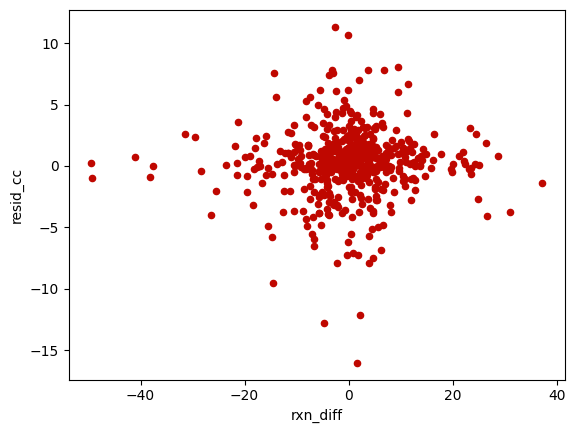

In [62]:
test_df = measurements.join(reactions["rxn_diff"])
test_df = test_df.loc[(test_df["rxn_diff"] > 1e-5) | (test_df["rxn_diff"] < -1e-5)]
test_df.plot.scatter("rxn_diff", "resid_cc")